# Inference

In this lab we will discuss some inference problems

In [3]:
from rule import Rule
from cfg import WCFG, read_grammar_rules
from parser import cky
from earley import earley
from symbol import make_symbol, is_nonterminal, is_terminal
import numpy as np
from collections import defaultdict

In [103]:
# let's use our ambiguous grammar this time
G = WCFG(read_grammar_rules(open('examples/ambiguous', 'r')))
print G

[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [5]:
sentence = 'a + a * a'.split()
sentence

['a', '+', 'a', '*', 'a']

In [81]:
forest = cky(G, sentence)

In [82]:
print forest

[E:2-3] -> [T:2-3] (0.5)
[E:4-5] -> [T:4-5] (0.5)
[T:0-3] -> [T:0-1] + [P:2-3] (0.1)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[E:0-5] -> [T:0-5] (0.5)
[E:0-5] -> [E:0-3] * [T:4-5] (0.05)
[E:0-5] -> [E:0-1] + [T:2-5] (0.45)
[T:0-1] -> [P:0-1] (0.5)
[E:0-1] -> [T:0-1] (0.5)
[E:0-3] -> [E:0-1] + [T:2-3] (0.45)
[E:0-3] -> [T:0-3] (0.5)
[E:2-5] -> [E:2-3] * [T:4-5] (0.05)
[E:2-5] -> [T:2-5] (0.5)
[P:0-1] -> a (1.0)
[T:4-5] -> [P:4-5] (0.5)
[P:2-3] -> a (1.0)
[T:2-5] -> [T:2-3] * [P:4-5] (0.4)
[T:2-3] -> [P:2-3] (0.5)
[P:4-5] -> a (1.0)


Reminder: the goal symbol after parsing is the original *start* symbol annotated from *0* to *n* (the length of the sentence).

In [8]:
goal = make_symbol('[E]', 0, len(sentence))
goal

'[E:0-5]'

We can also use earley to parse the sentence. For this we also need to pass the parser the start symbol that we are using, as earley uses this to produce its axioms.

In [99]:
earley_forest = earley(G, sentence, start='[E]')
print earley_forest

[T:0-3] -> [T:0-1] + [P:2-3] (0.1)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[E:0-5] -> [T:0-5] (0.5)
[E:0-5] -> [E:0-3] * [T:4-5] (0.05)
[E:0-5] -> [E:0-1] + [T:2-5] (0.45)
[T:0-1] -> [P:0-1] (0.5)
[E:0-1] -> [T:0-1] (0.5)
[E:0-3] -> [E:0-1] + [T:2-3] (0.45)
[E:0-3] -> [T:0-3] (0.5)
[P:0-1] -> a (1.0)
[T:4-5] -> [P:4-5] (0.5)
[P:2-3] -> a (1.0)
[T:2-5] -> [T:2-3] * [P:4-5] (0.4)
[T:2-3] -> [P:2-3] (0.5)
[P:4-5] -> a (1.0)


Notice that the forest generated by Earley are smaller than the forest generated by CKY: Earley has a built-in top-down filter that removes redundant elements.

In [102]:
print len(forest)
print len(earley_forest)

19
15


# Generate a corpus

We can use a grammar generate a corpus using ancestral sampling. Here we use the ambiguous grammar given above.

In [14]:
def generate_sample(grammar, items=('[E]',)):
    """
    Given a grammar returns a sentence from it using
    the probabilities specfied in the grammar.
    :param items: call the function with (start,) where 
                  start is the start symbol of the grammar
    :returns: a sentence from the language as a list
    """
    frags = []
    for item in items:
        if is_nonterminal(item):
            productions = grammar.get(item)
            ps = [production.prob for production in productions]
            random_index = np.argmax(np.random.multinomial(1, ps, size=1))
            prod = productions[random_index]
            frags.extend(generate_sample(grammar, items=prod.rhs))
        else:
            frags.append(item)
    return frags

# print generate_sample(G)

def generate_corpus(grammar, n, start=('[E]',),):
    """
    Generates a corpus using the grammar
    :param n: size of the corpus
    :params: same a s generate corpus
    :returns: a corpus in the form of a list
    """
    return [generate_sample(grammar, items=start) for i in range(n)]

corpus1 = generate_corpus(G, 100)
corpus2 = generate_corpus(G, 1000)
corpus3 = generate_corpus(G, 10000)

print corpus1

[['a', '*', 'a', '*', 'a', '*', 'a', '*', 'a', '+', 'a'], ['a', '*', 'a', '*', 'a', '*', 'a'], ['a'], ['a', '*', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a', '*', 'a', '+', 'a', '*', 'a', '+', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a', '*', 'a', '+', 'a'], ['a', '+', 'a'], ['a', '*', 'a'], ['a', '*', 'a', '*', 'a', '*', 'a'], ['a', '*', 'a', '+', 'a', '*', 'a', '+', 'a'], ['a', '+', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a'], ['a'], ['a', '*', 'a'], ['a', '+', 'a'], ['a', '*', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '+', 'a'], ['a', '+', 'a'], ['a', '+', 'a', '*', 'a', '+', 'a', '+', 'a', '+', 'a', '+', 'a', '*', 'a'], ['a'], ['a', '+', 'a', '+', 'a'], ['a', '*', 'a'], ['a', '*', 'a', '*', 'a', '*', 'a'], ['a'], ['a', '+', 'a'], ['a', '+', 'a', '+', 'a', '+', 'a', '*', 'a'], ['a', '+', 'a'], ['a', '+', 'a', '+', 'a', '*', 'a', '+', 'a', '+', 'a', '*', 'a', '*', 'a'], ['a', '+', 'a', '+', 'a'], ['a', '*', 'a', '*', 'a', '+'

In [15]:
sentence2 = corpus1[1]

forest2 = cky(G, sentence2)
print forest2

[T:2-7] -> [T:2-5] * [P:6-7] (0.4)
[E:0-3] -> [E:0-1] * [T:2-3] (0.05)
[E:0-3] -> [T:0-3] (0.5)
[P:0-1] -> a (1.0)
[E:0-7] -> [E:0-1] * [T:2-7] (0.05)
[E:0-7] -> [E:0-3] * [T:4-7] (0.05)
[E:0-7] -> [E:0-5] * [T:6-7] (0.05)
[E:0-7] -> [T:0-7] (0.5)
[T:0-3] -> [T:0-1] * [P:2-3] (0.4)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[T:0-1] -> [P:0-1] (0.5)
[T:2-5] -> [T:2-3] * [P:4-5] (0.4)
[T:2-3] -> [P:2-3] (0.5)
[T:4-7] -> [T:4-5] * [P:6-7] (0.4)
[T:6-7] -> [P:6-7] (0.5)
[E:6-7] -> [T:6-7] (0.5)
[T:4-5] -> [P:4-5] (0.5)
[P:6-7] -> a (1.0)
[P:2-3] -> a (1.0)
[T:0-7] -> [T:0-5] * [P:6-7] (0.4)
[E:4-5] -> [T:4-5] (0.5)
[E:4-7] -> [T:4-7] (0.5)
[E:4-7] -> [E:4-5] * [T:6-7] (0.05)
[E:2-3] -> [T:2-3] (0.5)
[E:0-5] -> [T:0-5] (0.5)
[E:0-5] -> [E:0-3] * [T:4-5] (0.05)
[E:0-5] -> [E:0-1] * [T:2-5] (0.05)
[E:0-1] -> [T:0-1] (0.5)
[E:2-5] -> [E:2-3] * [T:4-5] (0.05)
[E:2-5] -> [T:2-5] (0.5)
[P:4-5] -> a (1.0)
[E:2-7] -> [E:2-3] * [T:4-7] (0.05)
[E:2-7] -> [T:2-7] (0.5)
[E:2-7] -> [E:2-5] * [T:6-7] (0.05)


In [16]:
goal2 = make_symbol('[E]', 0, len(sentence2))

I2 = inside(forest2, goal2)

print I2

NameError: name 'inside' is not defined

# An alternative grammar

Here we generate a corpus from a grammar taken from the NLTK toolkit. We use a Dirichlet distribution to give the productions random probabilities. Larger alpha gives more uniform distributions; smaller alpha gives more biased distributions. 

In [11]:
toy_grammar = WCFG(read_grammar_rules(open('examples/nltk-grammar', 'r')))
# print toy_grammar

# We give the grammar some random probabilities 
# that are not too uniform and moderately biased:
toy_grammar = initialize(toy_grammar, alpha=0.5)
print toy_grammar

NameError: name 'initialize' is not defined

From this grammar we can also generate a corpus. Note that the sentences can have an enormous number of different parses. The grammar can quite easliy generate very long sentences, and is very ambiguous.

In [513]:
generate_sample(toy_grammar, items=('[S]',))
toy_corpus = generate_corpus(toy_grammar, 100, start=('[S]',))
print toy_corpus[0:10]

def checking_number_parses(n=100):
    number = list()
    for sentence in toy_corpus[0:n]:
        toy_forest = cky(toy_grammar, sentence)
        toy_goal = make_symbol('[S]', 0, len(sentence))
        N_toy = counting(toy_forest, toy_goal)
        number.append(N_toy[toy_goal])
    return number

print checking_number_parses()

[['Jack', 'ate'], ['Jack', 'with', 'Jack', 'with', 'Jack', 'with', 'Jack', 'saw'], ['Jack', 'ate'], ['Jack', 'saw'], ['Jack', 'ate'], ['Jack', 'saw'], ['the', 'hill', 'under', 'Jack', 'ate'], ['Jack', 'saw'], ['Jack', 'saw', 'Bob'], ['Jack', 'saw', 'Jack']]
[1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 429, 1, 1, 1, 117572, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 2, 1, 1, 1, 1, 14, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 132, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 742900, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 2, 14, 2, 1]


# Drawing the parse

In [39]:
d2 = viterbi(forest2, I2, goal2)

print d2
t2 = make_nltk_tree(d2)
print t2
t2.draw()

[[E:0-15] -> [E:0-13] + [T:14-15] (0.45), [E:0-13] -> [E:0-11] + [T:12-13] (0.45), [T:14-15] -> [P:14-15] (0.5), [E:0-11] -> [E:0-7] + [T:8-11] (0.45), [T:12-13] -> [P:12-13] (0.5), [P:14-15] -> a (1.0), [E:0-7] -> [E:0-1] + [T:2-7] (0.45), [T:8-11] -> [T:8-9] * [P:10-11] (0.4), [P:12-13] -> a (1.0), [E:0-1] -> [T:0-1] (0.5), [T:2-7] -> [T:2-5] * [P:6-7] (0.4), [T:8-9] -> [P:8-9] (0.5), [P:10-11] -> a (1.0), [T:0-1] -> [P:0-1] (0.5), [T:2-5] -> [T:2-3] * [P:4-5] (0.4), [P:6-7] -> a (1.0), [P:8-9] -> a (1.0), [P:0-1] -> a (1.0), [T:2-3] -> [P:2-3] (0.5), [P:4-5] -> a (1.0), [P:2-3] -> a (1.0)]
(E:0-15
  (E:0-13
    (E:0-11
      (E:0-7
        (E:0-1 (T:0-1 (P:0-1 a)))
        +
        (T:2-7 (T:2-5 (T:2-3 (P:2-3 a)) * (P:4-5 a)) * (P:6-7 a)))
      +
      (T:8-11 (T:8-9 (P:8-9 a)) * (P:10-11 a)))
    +
    (T:12-13 (P:12-13 a)))
  +
  (T:14-15 (P:14-15 a)))


In [40]:
N2 = counting(forest2, goal2)
print N2[goal2]

128


# Inside weights

The inside recursion accumulates the weight of all subtrees under a certain node.

        I(v) = 
            1                           if v is terminal
            0                           if v is nonterminal and BS(v) is empty
            
$$\sum_{e \in BS(v)} w(e) \prod_{u \in tail(e)} I(u)$$
                                        otherwise
                                        
Here we are going to compute inside weights for acyclic forests, for a more general treatment see Goodman's "Semiring Parsing" paper (1999).

Inside weights can be used, for instance, to answer the question:

* what is the probability of sentence x?

It can also be used to find the best derivation and to sample derivations, as we will show below.

In [17]:
def inside(forest, start):  # acyclic hypergraph
    """
    The inside recursion for acyclic hypergraphs.
    
    :param forest: an acyclic WCFG
    :param start: the start symbol (str)
    :returns: a dictionary mapping a symbol (terminal or noterminal) to its inside weight
    """
    I = dict()
    
    def get_inside(symbol):
        """computes inside recursively"""
        w = I.get(symbol, None)
        if w is not None:  # already computed
            return w
        incoming = forest.get(symbol, set())
        if len(incoming) == 0:  # terminals have already been handled, this must be a nonterminal dead end
            # store it to avoid repeating computation in the future
            I[symbol] = 0.0
            return 0.0
        # accumulate the inside contribution of each incoming edge
        w = 0.0
        for rule in incoming:
            k = rule.prob
            for child in rule.rhs:
                k *= get_inside(child)
            w += k
        # store it to avoid repeating computation in the future
        I[symbol] = w
        return w
    
    # handles terminals
    for sym in forest.terminals:
        I[sym] = 1.0
    # recursively solves the inside formula from the start symbol
    get_inside(start)
        
    return I

In [18]:
I = inside(forest, goal)

print I

{'a': 1.0, '[T:0-3]': 0.05, '[T:0-5]': 0.020000000000000004, '[E:0-5]': 0.034531250000000006, '[T:0-1]': 0.5, '+': 1.0, '*': 1.0, '[E:0-3]': 0.08125, '[T:2-3]': 0.5, '[P:0-1]': 1.0, '[T:4-5]': 0.5, '[P:2-3]': 1.0, '[T:2-5]': 0.2, '[E:0-1]': 0.25, '[P:4-5]': 1.0}


The inside at the root represents the probability of the sentence:

$$p(x) = \sum_d p(x, d)$$

# Outside

Computing outside probabilities.


In [101]:
def get_rules_by_rhs(grammar, symbol):
    rules = []
    for rule in grammar:
#         print rule
        if symbol in rule.rhs:
            rules.append(rule)
    return rules

print get_rules_by_rhs(forest2, '[T:2-5]')

[[T:2-7] -> [T:2-5] * [P:6-7] (0.4), [E:0-5] -> [E:0-1] * [T:2-5] (0.05), [E:2-5] -> [T:2-5] (0.5)]


In [21]:
def outside(forest, start, inside_dict):
    
    I = dict()
    
    def get_outside(symbol):
        w = I.get(symbol, None)
        if w is not None:  # already computed
            return w
        outgoing = get_rules_by_rhs(forest, symbol)
        beta = 0.0
        for rule in outgoing:
            k = rule.prob
            for child in rule.rhs:
                if child != symbol:
                    try:
                        alpha = inside_dict[child]
                    except KeyError:
                        # Not sure about this solution...
                        # If child is not in inside_dict then child was not seen in the top-down process
                        # of the inside algorithm, and hence there is no way to complete child into a 
                        # parse for the whole sentence. So beta should be 0.0
#                         print "key-error with {}".format(child)
                        alpha = 0.0
                    k *= alpha
            k *= get_outside(rule.lhs)
            beta += k
        I[symbol] = beta
        return beta
    
    I[start] = 1.0
    
    for sym in forest.terminals:
#         print "terminal: {}".format(sym)
        I[sym] = get_outside(sym)
    
    return I

In [22]:
print outside(forest, goal, I)

{'a': 0.10359375000000001, '[E:2-3]': 0.0, '[E:4-5]': 0.0, '[T:0-3]': 0.21250000000000002, '[T:0-5]': 0.5, '[E:0-5]': 1.0, '[T:0-1]': 0.06906250000000001, '[E:0-1]': 0.09562500000000002, '*': 0.03453125, '[E:0-3]': 0.025, '[T:4-5]': 0.0040625, '[P:0-1]': 0.034531250000000006, '[P:2-3]': 0.034531250000000006, '[E:2-5]': 0.0, '[T:2-5]': 0.1125, '+': 0.034531250000000006, '[T:2-3]': 0.04781250000000001, '[P:4-5]': 0.03453125}


# Inside-Outside

We use the inside-outside algorithm to learn probabilities of the rules from unlabeled data.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:

def initialize(grammar, alpha=20.0):
    """
    Takes a grammar and returns that same grammar but
    with the probabilities replaced by random probabilities
    generated from a Dirichlet distribution.
    :param: alpha is the Dirichlet concentration parameter
    """
    init_grammar = WCFG()
    for nonterminal in grammar.nonterminals:
        rules = grammar.get(nonterminal)
        init_prob = np.random.dirichlet(len(rules)*[alpha])
        for i, rule in enumerate(rules):
            init_grammar.add(Rule(rule.lhs, rule.rhs, init_prob[i]))
    return init_grammar

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_instances(rule, forest):
    """
    Given a rule
    
    A -> B C 
    
    get_instances collects all instances of rules of the form
    
    [A:i-j] -> [B:i-k] [C:k-j] 
    
    from the forest and returns them in a list.
    """
    instances = []
    for r in forest:
        if r.lhs[1] == rule.lhs[1] and len(r.rhs)==len(rule.rhs):
            test = []
            for i in range(len(r.rhs)):
                try:
                    # if for example r.rhs[i] = '[A]' 
                    v = r.rhs[i][1] == rule.rhs[i][1]
                    test.append(v)
                except IndexError:
                    # if for example r.rhs[i] = '*' 
                    v = r.rhs[i][0] == rule.rhs[i][0]
                    test.append(v)
            if np.all(test):
                instances.append(r)
    return instances

def inside_outside(training_sents, grammar, start_sym='[E]'):
    f = defaultdict(float)
    for sent in training_sents:
        forest = cky(grammar, sent)
        goal = make_symbol(start_sym, 0, len(sent))
        I = inside(forest, goal)
        O = outside(forest, goal, I)     
        for rule in grammar:
            w = 0.0
            for instance in get_instances(rule, forest):
                k = rule.prob
                k *= O[instance.lhs]
                for child in instance.rhs:
                    try:
                        alpha = I[child]
                    except KeyError:
                        # same solution as in outside
                        alpha = 0.0
                    k *= alpha
                w += k
            f[rule] += w/I[goal]
    return f

def EM(training_sents, grammar, n, start_sym='[E]', prin=False):
    if prin == True:
        print "Initalized grammar:\n{}\n".format(grammar)
    step = 0
    while step < n:
        
        # E-step
        f = inside_outside(training_sents, grammar, start_sym=start_sym)
                
        #M-step
        new_grammar = WCFG()
        for rule in grammar:
            new_prob = f[rule]/sum([f[r] for r in grammar.get(rule.lhs)])
            new_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))
        
        grammar = new_grammar
        
        step +=1   
    return grammar

In [97]:
print hdp_pcfg
f = inside_outside(hdp_corpus, hdp_pcfg, start_sym='[S]')
print f

s = 0
for sent in hdp_corpus:
    s += sum(map(lambda x : x=='mouse', sent))
print s

[NN] -> mouse (0.33)
[NN] -> cat (0.33)
[NN] -> dog (0.34)
[JJ] -> big (0.5)
[JJ] -> black (0.5)
[DT] -> the (0.5)
[DT] -> a (0.5)
[NPBAR] -> [JJ] [NN] (0.5)
[NPBAR] -> [JJ] [NPBAR] (0.5)
[VP] -> [VB] [NP] (1.0)
[S] -> [NP] [VP] (1.0)
[VB] -> chased (0.5)
[VB] -> ate (0.5)
[NP] -> [DT] [NN] (0.5)
[NP] -> [DT] [NPBAR] (0.5)
defaultdict(<type 'float'>, {[NN] -> mouse (0.33): 135.94117647058815, [DT] -> the (0.5): 97.0, [VP] -> [VB] [NP] (1.0): 100.0, [JJ] -> black (0.5): 126.0, [NN] -> cat (0.33): 62.0, [NPBAR] -> [JJ] [NPBAR] (0.5): 234.0, [NN] -> dog (0.34): 140.0606060606061, [S] -> [NP] [VP] (1.0): 100.0, [JJ] -> big (0.5): 108.0, [NPBAR] -> [JJ] [NN] (0.5): 234.0, [DT] -> a (0.5): 103.0, [VB] -> chased (0.5): 52.0, [NP] -> [DT] [NN] (0.5): 200.0, [VB] -> ate (0.5): 48.0, [NP] -> [DT] [NPBAR] (0.5): 200.0})
68


In [84]:
print init_grammar
print '\n'

f = inside_outside(corpus1, init_grammar, start_sym='[E]')

new_grammar = WCFG()
for rule in init_grammar:
    new_prob = f[rule]/sum([f[r] for r in init_grammar.get(rule.lhs)])
    new_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))
print new_grammar
print '\n'

f = inside_outside(corpus1, new_grammar, start_sym='[E]')

newnew_grammar = WCFG()
for rule in new_grammar:
    new_prob = f[rule]/sum([f[r] for r in new_grammar.get(rule.lhs)])
    newnew_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))
print newnew_grammar
print '\n'


[T] -> [P] (0.301961046813)
[T] -> [T] * [P] (0.331971218888)
[T] -> [T] + [P] (0.366067734298)
[E] -> [T] (0.320911968357)
[E] -> [E] + [T] (0.338503601884)
[E] -> [E] * [T] (0.340584429759)
[P] -> a (1.0)


[T] -> [P] (0.424384292978)
[T] -> [T] * [P] (0.301117234145)
[T] -> [T] + [P] (0.274498472878)
[E] -> [T] (0.59958139455)
[E] -> [E] + [T] (0.180606508201)
[E] -> [E] * [T] (0.219812097249)
[P] -> a (1.0)


[T] -> [P] (0.424384292978)
[T] -> [T] * [P] (0.301117234145)
[T] -> [T] + [P] (0.274498472878)
[E] -> [T] (0.59958139455)
[E] -> [E] + [T] (0.180606508201)
[E] -> [E] * [T] (0.219812097249)
[P] -> a (1.0)




In [ ]:
# SOMEHOW this does not work... Why?
G = WCFG(read_grammar_rules(open('examples/ambiguous', 'r')))
init_grammar = initialize(G)

print G
print '\n'
print init_grammar
print '\n'
new_grammar = EM(corpus2, init_grammar, 1)
print new_grammar
print '\n'
new_new_grammar = EM(corpus2, new_grammar, 1)
print new_new_grammar

## Plotting progress

We use pyplot to show the progress in the parameter estimation. 

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_EM(corpus, grammar, n, start_sym='[E]', init=False):
    
    d = defaultdict(list)
    for rule in grammar: # save the true grammar probs
        ruled = Rule(rule.lhs, rule.rhs, 1.0) # make sure the dict entries do not depend on the rule probs
        d[ruled].append(rule.prob)
    
    if init == True:
        grammar = initialize(grammar)
    
    i = 0
#     while i < n:
    for i in range(n):
        print "round {}".format(i)
        new_grammar = EM(corpus, grammar, 1, start_sym=start_sym, prin=False)
        for rule in new_grammar:
            ruled = Rule(rule.lhs, rule.rhs, 1.0)
            d[ruled].append(rule.prob)
#             print "rule {0}, prob {1}, rule-prob {2}".format(rule, d[ruled], rule.prob)
        
        grammar = WCFG()
        for rule in new_grammar:
            grammar.add(rule)
#         grammar = new_grammar
#         i += 1

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    i = 0
    for rule, prob in d.iteritems():
        plt.plot(range(n+1), prob, color=colors[i%len(colors)])
        plt.plot(range(n+1), [prob[0]]*(n+1), '--', color=colors[i%len(colors)])
        i += 1
        
    plt.show()

round 0
round 1
round 2


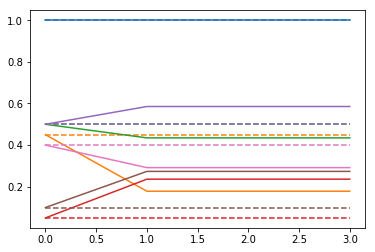

In [83]:
plot_EM(corpus1, G, 3, init=True)

[NN] -> mouse (0.33)
[NN] -> cat (0.33)
[NN] -> dog (0.34)
[JJ] -> big (0.5)
[JJ] -> black (0.5)
[DT] -> the (0.5)
[DT] -> a (0.5)
[NPBAR] -> [JJ] [NN] (0.5)
[NPBAR] -> [JJ] [NPBAR] (0.5)
[VP] -> [VB] [NP] (1.0)
[S] -> [NP] [VP] (1.0)
[VB] -> chased (0.5)
[VB] -> ate (0.5)
[NP] -> [DT] [NN] (0.5)
[NP] -> [DT] [NPBAR] (0.5)
round 0
round 1
round 2


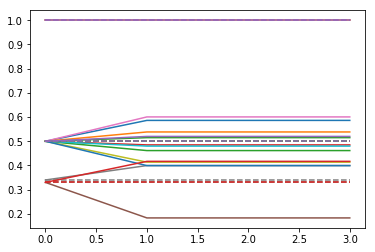

In [80]:
hdp_pcfg = WCFG(read_grammar_rules(open('examples/hdp-pcfg-grammar', 'r')))
print hdp_pcfg
hdp_corpus = generate_corpus(hdp_pcfg, 100, start=('[S]',))

plot_EM(hdp_corpus, hdp_pcfg, 3, start_sym='[S]', init=True)

## Training on the grammar G

In [446]:
print EM(corpus1, init_grammar, 5)
print '\n'
print G

Initalized grammar:
[T] -> [P] (0.336767037132)
[T] -> [T] * [P] (0.249669565353)
[T] -> [T] + [P] (0.413563397515)
[E] -> [T] (0.383779381797)
[E] -> [E] + [T] (0.269130910633)
[E] -> [E] * [T] (0.34708970757)
[P] -> a (1.0)

[T] -> [P] (0.441357063964)
[T] -> [T] * [P] (0.308400115141)
[T] -> [T] + [P] (0.250242820895)
[E] -> [T] (0.548605132613)
[E] -> [E] + [T] (0.124257498849)
[E] -> [E] * [T] (0.327137368539)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [380]:
print EM(corpus2, init_grammar, 5)
print '\n'
print G

Inital grammar:
[T] -> [P] (0.332696712064)
[T] -> [T] * [P] (0.395653638165)
[T] -> [T] + [P] (0.271649649771)
[E] -> [T] (0.281053698826)
[E] -> [E] + [T] (0.327620451643)
[E] -> [E] * [T] (0.391325849531)
[P] -> a (1.0)

[T] -> [P] (0.448748514495)
[T] -> [T] * [P] (0.317777574063)
[T] -> [T] + [P] (0.233473911442)
[E] -> [T] (0.558221350963)
[E] -> [E] + [T] (0.208759236296)
[E] -> [E] * [T] (0.233019412741)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


## Training on the NLTK toy-grammar

In [514]:
init_toy_grammar = initialize(toy_grammar)
# print init_toy_grammar

approx_grammar = EM(toy_corpus, init_toy_grammar, 1, start_sym='[S]', prin=True)
print '\nApproximated grammar:'
print approx_grammar
print '\nOriginal grammar:'
print toy_grammar

def difference_grammar(one, another):
    diff_grammar = WCFG()
    for rule in one:
        for r in another:
            if r.rhs == rule.rhs and r.lhs == rule.lhs:
                approx_prob = r.prob
                break
        diff_grammar.add(Rule(rule.lhs, rule.rhs, abs(rule.prob-approx_prob)))
    return diff_grammar

print '\nDifference grammar:'
print difference_grammar(toy_grammar, approx_grammar)

Initalized grammar:
[PP] -> [P] [NP] (1.0)
[N] -> boy (0.213626231189)
[N] -> cookie (0.251407938717)
[N] -> table (0.173580173222)
[N] -> telescope (0.154630860257)
[N] -> hill (0.206754796615)
[Det] -> the (0.280428681323)
[Det] -> a (0.445360447257)
[Det] -> my (0.27421087142)
[V] -> saw (0.249916787884)
[V] -> ate (0.297907226313)
[V] -> ran (0.452175985803)
[Name] -> Bob (0.481151564908)
[Name] -> Jack (0.518848435092)
[VP] -> [V] [NP] (0.32846516725)
[VP] -> [V] (0.288795071913)
[VP] -> [VP] [PP] (0.382739760838)
[S] -> [NP] [VP] (1.0)
[P] -> with (0.529596890353)
[P] -> under (0.470403109647)
[NP] -> [Det] [N] (0.407826990509)
[NP] -> [Name] (0.36382543937)
[NP] -> [NP] [PP] (0.228347570121)


Approximated grammar:
[PP] -> [P] [NP] (1.0)
[N] -> boy (0.0361376056237)
[N] -> cookie (0.0425288640327)
[N] -> table (0.770175226412)
[N] -> telescope (0.0)
[N] -> hill (0.151158303931)
[Det] -> the (0.571428571429)
[Det] -> a (0.357142857143)
[Det] -> my (0.0714285714286)
[V] -> saw (0.

# Counting derivations

Another interesting question is

* how many analyses of a given sentence do we have?

This question is very simple to answer for acyclic hypergraphs and it turns out to be a special case of the inside recursion.

        N(v) = 
            1                           if v is terminal
            0                           if v is nonterminal and BS(v) is empty

$$\sum_{e \in BS(v)} 1 * \prod_{u \in tail(e)} N(u)$$
                                        otherwise
                                        
Compare the definition above with the inside recursion presented earlier.
Also compare the program below with the inside computation and comment on the differences.

Can you explain this recursion?

In [18]:
def counting(forest, start):  # acyclic hypergraph
    N = dict()
    
    def get_count(symbol):
        w = N.get(symbol, None)
        if w is not None:
            return w
        incoming = forest.get(symbol, set())
        if len(incoming) == 0:  # terminals have already been handled, this must be a nonterminal dead end
            N[symbol] = w
            return 0
        w = 0
        for rule in incoming:
            k = 1
            for child in rule.rhs:
                k *= get_count(child)
            w += k
        N[symbol] = w
        return w
    
    # handles terminals
    for sym in forest.terminals:
        N[sym] = 1
    # handles nonterminals
    #for sym in forest.nonterminals:
    #    get_inside(sym)
    get_count(start)
        
    return N

In [23]:
N = counting(forest, goal)

The total number of derivations is associated with the value of N at the root.

In [24]:
N[goal]

4

# Viterbi (best derivation)

We might want to know which analysis score highest. That is,

        d* = argmax_d p(x, d)
        
where d ranges over all possible derivations.

Once we have computed inside weights, this is extremely simple to solve.
However, we can also define a recursion which is specific for the computation of the Viterbi derivation. Do you think you can come up with its formula? Can you implement it?
        
        
Below, an implementation based on inside weights.

In [19]:
from collections import deque
def viterbi(forest, I, start):
    Q = deque([start])
    d = []
    while Q:
        parent = Q.popleft()
        incoming = forest.get(parent)
        # here we will find the distribution over edges
        weights = [0.0] * len(incoming)
        for i, rule in enumerate(incoming):
            weights[i] = rule.prob
            for child in rule.rhs:
                weights[i] *= I[child]
        # here we select the edge that is the maximum of this distribution
        weight, selected = max(zip(weights, incoming))
        # we also need to queue the nonterminals in the tail of the edge
        for sym in selected.rhs:
            if is_nonterminal(sym):
                Q.append(sym)
        # and finally, add the selected edge to the derivation
        d.append(selected)
    return d

In [26]:
d = viterbi(forest, I, goal)
d

[[E:0-5] -> [E:0-1] + [T:2-5] (0.45),
 [E:0-1] -> [T:0-1] (0.5),
 [T:2-5] -> [T:2-3] * [P:4-5] (0.4),
 [T:0-1] -> [P:0-1] (0.5),
 [T:2-3] -> [P:2-3] (0.5),
 [P:4-5] -> a (1.0),
 [P:0-1] -> a (1.0),
 [P:2-3] -> a (1.0)]

The joint probability p(d, x) of the derivation is given by the product over its rules

In [20]:
def joint_probability(d):
    prob = 1.0
    for rule in d:
        prob *= rule.prob
    return prob

In [416]:
joint_probability(d)

0.0006250000000000001

The conditional probability p(d|x) is given by

    p(d|x) = p(d,x)/p(x)

and we know that 

    p(x) = \sum_d p(d,x)
    
is given by the inside at the root.

Thus, the following is the conditional probability of the best derivation:

In [29]:
joint_probability(d)/I[goal]

0.6515837104072397

In [21]:
# We can use this utilitary method to draw trees
from util import make_nltk_tree

In [31]:
t = make_nltk_tree(d)
print t

(E:0-5
  (E:0-1 (T:0-1 (P:0-1 a)))
  +
  (T:2-5 (T:2-3 (P:2-3 a)) * (P:4-5 a)))


*the following will open a pop-up window and you need to find it ;)*


In [32]:
t.draw()

# Sampling

Often we are interested in drawing random samples from the distribution p(d|x).

We can do that by sampling from the inverted CDF associated with p(d|x).
The conditional independence assumption central to PCFGs make them convenient for sampling by *ancestral sampling*.

The code below is very similar to the Viterbi code above, however, instead of maximising at each step, we draw a random edge from the distribution defined by their inside weights. 

In [57]:
from collections import deque
import random
def sample(forest, I, start):
    Q = deque([start])
    d = []
    while Q:
        parent = Q.popleft()
        incoming = forest.get(parent)
        # here we compute the distribution over edges
        weights = [0.0] * len(incoming)
        for i, rule in enumerate(incoming):
            weights[i] = rule.prob
            for child in rule.rhs:
                weights[i] *= I[child]
        # here we draw a random threshold (think of it as sampling from the inverted CDF)
        th = random.uniform(0, I[parent])
        # here we compute the CDF step by step and check
        # for which edge e whether cdf(e) > th
        total = 0.0
        selected = None
        back = None
        for w, rule in zip(weights, incoming):
            total += w
            if total > th:
                selected = rule
                break
            else:
                back = rule
        if selected is None:  # this is to deal with corner cases due to rounding problems
            selected = back
        # every nonterminal child of the selected edge must be added to the queue
        for sym in selected.rhs:
            if is_nonterminal(sym):
                Q.append(sym)
        d.append(selected)
    return d

Here we draw a random sample

In [67]:
sample(forest, I, goal)

[[E:0-5] -> [T:0-5] (0.5),
 [T:0-5] -> [T:0-3] * [P:4-5] (0.4),
 [T:0-3] -> [T:0-1] + [P:2-3] (0.1),
 [P:4-5] -> a (1.0),
 [T:0-1] -> [P:0-1] (0.5),
 [P:2-3] -> a (1.0),
 [P:0-1] -> a (1.0)]

## Empirical distribution

A nice thing to do whe we can sample is to obtain an empirical distribution.
That is, we draw a number of independent samples from the underlying distribution and approximate their probabilities by their relative frequency in the sample. The law of large numbers says that our estimates converge to true probabilities as we sample more. That also holds for expectations that we might want to compute based on the underlying distribution.

Note how our estimates are pretty close to the true probabilities. This is because we are drawing indepent samples from the exact conditional distribution p(d|x).

In [56]:
# an example of how to estimate an empirical distribution out of 100 samples
from collections import defaultdict
counts = defaultdict(int)
n_samples = 1000
# here we sample a number of derivations
for i in range(n_samples):
    d = tuple(sample(forest, I, goal))
    counts[d] += 1  # counting how often we they get sampled

# here we sort them by frequency from most frequent to least frequent
for d, n in sorted(counts.iteritems(), key=lambda (d, n): n, reverse=True):
    # here we compute the exact probability (for comparison)
    prob = joint_probability(d)/I[goal]
    # here we compute an empirical estimate
    estimate = float(n)/n_samples
    t = make_nltk_tree(d)
    print '# n=%d prob=%s estimate=%s\n%s' % (n, prob, estimate, str(t))
    print

# n=633 prob=0.651583710407 estimate=0.633
(E:0-5
  (E:0-1 (T:0-1 (P:0-1 a)))
  +
  (T:2-5 (T:2-3 (P:2-3 a)) * (P:4-5 a)))

# n=302 prob=0.289592760181 estimate=0.302
(E:0-5 (T:0-5 (T:0-3 (T:0-1 (P:0-1 a)) + (P:2-3 a)) * (P:4-5 a)))

# n=43 prob=0.0407239819005 estimate=0.043
(E:0-5
  (E:0-3 (E:0-1 (T:0-1 (P:0-1 a))) + (T:2-3 (P:2-3 a)))
  *
  (T:4-5 (P:4-5 a)))

# n=22 prob=0.0180995475113 estimate=0.022
(E:0-5
  (E:0-3 (T:0-3 (T:0-1 (P:0-1 a)) + (P:2-3 a)))
  *
  (T:4-5 (P:4-5 a)))



Note that our grammar, even though ambiguous, expresses a strong preference (a little over 65%) for the analysis that solves the product before the sum.